In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/densnet/densenet201_weights_tf_dim_ordering_tf_kernels_notop (1).h5
/kaggle/input/dentistry/README.dataset.txt
/kaggle/input/dentistry/README.roboflow.txt
/kaggle/input/dentistry/valid/0000275_png_jpg.rf.b1f4cd7a4974409ce677aa4e1e00139c.jpg
/kaggle/input/dentistry/valid/0000346_png_jpg.rf.06b893e5dc76b5a4f8950dfb631c168b.jpg
/kaggle/input/dentistry/valid/0000248_png_jpg.rf.ef838c07bc6194fa54602e1b063fa06d.jpg
/kaggle/input/dentistry/valid/0000164_png_jpg.rf.f54ef350f6bf8be670d44ff0beb9d2ef.jpg
/kaggle/input/dentistry/valid/0000426_png_jpg.rf.40d108098166d592522a6af43c8f5fa3.jpg
/kaggle/input/dentistry/valid/0000144_png_jpg.rf.aaaeadd7e8a15e69d1ee522095e12a07.jpg
/kaggle/input/dentistry/valid/0000161_png_jpg.rf.ce51e0e3d7158685a04d453e6c8b4112.jpg
/kaggle/input/dentistry/valid/0000271_png_jpg.rf.02cdaf5e83a1840e2f6e3d1ffbd21ec8.jpg
/kaggle/input/dentistry/valid/0000127_png_jpg.rf.b28f9a65fd06ec0c2ce0c66d475f1c54.jpg
/kaggle/input/dentistry/valid/0000187_png_jpg.rf.ac05ab91

# Import Lib

In [19]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.applications import Xception,ResNet50, DenseNet201,MobileNet, EfficientNetB0, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, MaxPooling2D, Add, AveragePooling2D, Flatten,Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.layers import Layer,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import add
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import multiply
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint


SEED = 10
IMG_SIZE = 256, 256
BATCH_SIZE = 64

# Read Data

Text(0.5, 1.0, 'after image processing operations')

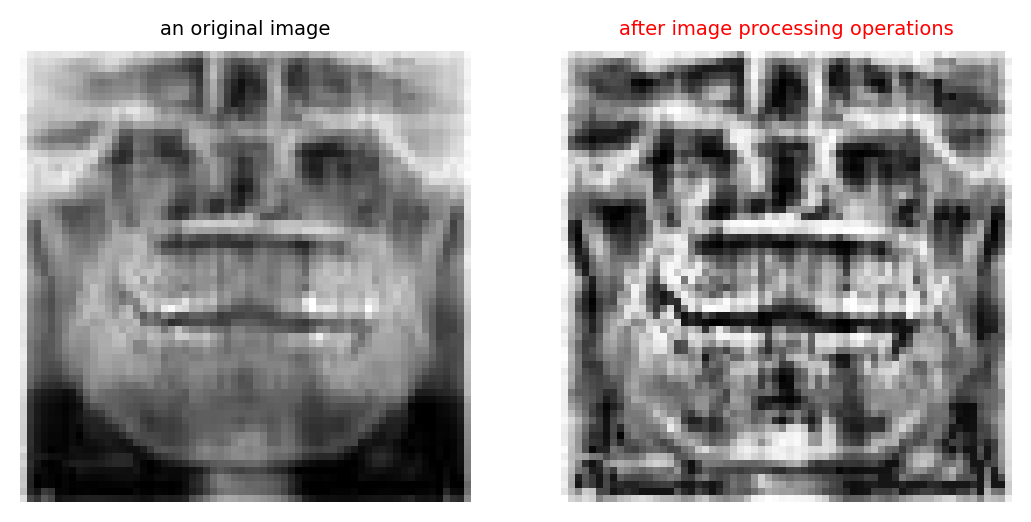

In [66]:
# chosing a random image from the train dataset
original_train_images =  sorted(os.listdir('/kaggle/input/dentistry/train'))
org_img_path =  np.random.permutation(original_train_images)[0]
img = cv2.imread(os.path.join('/kaggle/input/dentistry/train',org_img_path))[:,::,1]


# A basic segmentation of the image from the background
# In this stage I wanted to reduce the white pixel number 
img2 = img - 255
kernel = np.ones((2,2))
kernel2 = np.ones((3,3))
dilated_mask = cv2.dilate(img2, kernel, iterations = 3)
ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY) 
dilated_mask2 = cv2.dilate(thresh, kernel2, iterations = 3)
img = img / 255.0
res_img = dilated_mask2*img
res_img = np.uint8(res_img)
# CLAHE operation
clahe_op = cv2.createCLAHE(clipLimit= 20)
final_img = clahe_op.apply(res_img)
    
fig, axs = plt.subplots(1,2, dpi = 200)

axs[0].imshow(img,  cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('an original image', fontsize = 7)

axs[1].imshow(final_img,  cmap = 'gray')
axs[1].axis('off')
axs[1].set_title('after image processing operations', fontsize = 7, color = 'red')

In [4]:
# Creating new directories
os.mkdir(os.path.join('/kaggle/working/', 'train'))
os.mkdir(os.path.join('/kaggle/working/', 'valid'))


# Preprocessing

In [5]:
# Image processing function

def new_img(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        try:
            img = cv2.imread(os.path.join(main_path, i))[:,::,1]
            img2 = img - 255
            kernel = np.ones((2,2))
            kernel2 = np.ones((3,3))
            
            dilated_mask = cv2.dilate(img2, kernel, iterations = 3)
            ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY) 
            dilated_mask2 = cv2.dilate(thresh, kernel2, iterations = 3)
            img = img / 255.0
            res_img = dilated_mask2*img
            
            res_img = np.uint8(res_img)

            clahe_op = cv2.createCLAHE(clipLimit= 20) # CLAHE function
            final_img = clahe_op.apply(res_img)
            cv2.imwrite(os.path.join(target_path, i), final_img)
        except TypeError:
            pass

In [6]:
# Applying the image processing function to all images
new_img('/kaggle/input/dentistry/train', '/kaggle/working/train')
new_img('/kaggle/input/dentistry/valid', '/kaggle/working/valid')

# Read CSV file

In [7]:
train_data = pd.read_csv('/kaggle/input/dentistry/train/_classes.csv')
validation_data = pd.read_csv('/kaggle/input/dentistry/valid/_classes.csv')

# classes of label

classes = [
    '11', '12', '13', '14', '15', '16', '17', '18',
    '21', '22', '23', '24', '25', '26', '27', '28',
    '31', '32', '33', '34', '35', '36', '37', '38',
    '41', '42', '43', '44', '45', '46', '47', '48',
    'Crown', 'Implant', 'Root_Canal'
]
train_data['full_path'] = '/kaggle/working/train/' + train_data['filename']
validation_data['full_path'] = '/kaggle/working/valid/' + validation_data['filename']

print("train images: ", train_data.shape[0])
print("validation images: ", validation_data.shape[0])

train images:  452
validation images:  113


# Split image and label

In [8]:
x=train_data['full_path'] 
y = train_data.drop(columns=['full_path','filename'], axis=1)


In [9]:
x_valid=validation_data ['full_path'] 
y_valid = validation_data.drop(columns=['full_path','filename'], axis=1)

In [10]:
print(x)

0      /kaggle/working/train/0000119_png_jpg.rf.8d48d...
1      /kaggle/working/train/0000505_png_jpg.rf.8a7b5...
2      /kaggle/working/train/0000671_png_jpg.rf.8d68c...
3      /kaggle/working/train/0000078_png_jpg.rf.94395...
4      /kaggle/working/train/0000335_png_jpg.rf.8f79b...
                             ...                        
447    /kaggle/working/train/0000025_png_jpg.rf.85d42...
448    /kaggle/working/train/0000224_png_jpg.rf.8810b...
449    /kaggle/working/train/0000205_png_jpg.rf.87b1a...
450    /kaggle/working/train/0000700_png_jpg.rf.8a646...
451    /kaggle/working/train/0000489_png_jpg.rf.87d93...
Name: full_path, Length: 452, dtype: object


In [11]:
print(y)

      11   12   13   14   15   16   17   18   21   22  ...   42   43   44  \
0      1    1    1    1    1    1    0    0    1    1  ...    1    1    0   
1      1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
2      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
3      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
4      1    1    0    0    0    0    0    0    1    1  ...    1    1    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
447    1    1    1    1    1    0    0    1    1    1  ...    1    1    1   
448    1    1    0    0    0    1    1    1    1    1  ...    1    1    1   
449    0    1    0    0    0    1    1    0    1    1  ...    1    1    1   
450    1    1    1    1    0    0    1    0    1    1  ...    1    1    1   
451    0    1    1    1    1    1    1    1    0    0  ...    1    1    1   

      45   46   47   48   Crown   Implant   Root Canal  
0      0    0    0

In [12]:
print(y_valid)

      11   12   13   14   15   16   17   18   21   22  ...   42   43   44  \
0      0    1    1    1    1    1    1    1    0    1  ...    1    1    1   
1      1    1    0    0    0    0    0    0    1    1  ...    1    1    1   
2      1    0    0    1    1    1    1    0    1    1  ...    1    1    1   
3      1    1    1    1    1    0    1    1    1    1  ...    1    1    1   
4      1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
108    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
109    1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
110    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
111    1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
112    1    1    0    0    0    0    0    0    1    1  ...    1    1    1   

      45   46   47   48   Crown   Implant   Root Canal  
0      1    1    1

In [13]:
# Reading and resizing images
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size =  (IMG_SIZE) )
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Basic data augmentation - randomly flips left or right
def img_augmentation(image, label):

    radn_num = np.random.randint(0, 100)
    if radn_num % 2 == 0:
        img = tf.image.random_flip_left_right(image)
        return img, label
    else:
        return image, label

In [14]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((x, y ))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                 .map(img_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(train_data.shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))


valid_loader = tf.data.Dataset.from_tensor_slices((x_valid, y_valid ))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))




# DeneNet Model

In [31]:

pretrained_model = DenseNet201(weights='/kaggle/input/densnet/densenet201_weights_tf_dim_ordering_tf_kernels_notop (1).h5',include_top=False ,input_shape=[*IMG_SIZE, 3])
pretrained_model.trainable = True

inp = Input(shape = (*IMG_SIZE, 3))
densenet = pretrained_model(inp)
    
X = GlobalAveragePooling2D()(densenet)
X = Dense(256, activation = 'elu')(X)
X = Dropout(0.3)(X)
    
X = Dense(128, activation = 'elu')(X)
X = Dropout(0.2)(X)
    
X = Dense(32, activation = 'elu')(X)
    
out = Dense(35, activation = 'softmax')(X)
    
model = Model(inputs = inp, outputs = out)

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_1  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               491776    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                           

In [35]:
my_callbacks = [EarlyStopping(min_delta = 0.0001, monitor = 'loss', patience = 40 ),
                   ReduceLROnPlateau( monitor="val_loss", factor=0.1, patience=15)]

    
model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting Model

In [36]:
hist = model.fit(train_dataset, epochs = 16, validation_data = valid_dataset, callbacks = my_callbacks)

Epoch 1/16
8/8 [==============================] - 425s 44s/step - loss: 275.7795 - accuracy: 0.0000e+00 - val_loss: 740.1453 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/16
8/8 [==============================] - 359s 45s/step - loss: 1276.5853 - accuracy: 0.0000e+00 - val_loss: 2679.1714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/16
8/8 [==============================] - 341s 42s/step - loss: 3494.8413 - accuracy: 0.0000e+00 - val_loss: 4094.1621 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/16
8/8 [==============================] - 358s 45s/step - loss: 7601.5464 - accuracy: 0.0066 - val_loss: 2903.4102 - val_accuracy: 0.0177 - lr: 0.0010
Epoch 5/16
8/8 [==============================] - 346s 42s/step - loss: 16155.0996 - accuracy: 0.0155 - val_loss: 4701.1440 - val_accuracy: 0.0177 - lr: 0.0010
Epoch 6/16
8/8 [==============================] - 356s 44s/step - loss: 31827.2637 - accuracy: 0.0177 - val_loss: 16838.5117 - val_accuracy: 0.0177 - lr: 0.0010
Epoch 7/16
8/8 [=====

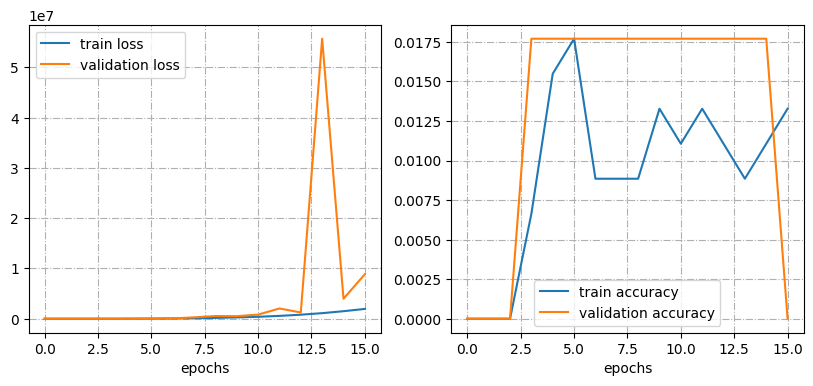

In [37]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['accuracy'])
axs[1].plot(hist.history['val_accuracy'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)

# ResNet Model

In [54]:
resnet50_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = '/kaggle/input/renet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5',
    input_shape = (*IMG_SIZE, 3))
resnet50_model.trainable = False

In [55]:
model_50 = tf.keras.models.Sequential([
    resnet50_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(35)])

In [56]:
model_50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                17955     
                                                                 
Total params: 24654755 (94.05 MB)
Trainable params: 1067043 (4.07 MB)
Non-trainable params: 23587712 (89.98 MB)
__________

In [62]:
model_50.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Fitting Model

In [63]:
resnet50_epochs = 100
history_50 = model_50.fit(train_dataset, validation_data=valid_dataset, epochs=resnet50_epochs)

Epoch 1/100
8/8 [==============================] - 97s 10s/step - loss: 185.7663 - accuracy: 0.0044 - val_loss: 193.8073 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 81s 10s/step - loss: 304.0506 - accuracy: 0.0022 - val_loss: 274.6286 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 82s 10s/step - loss: 435.9808 - accuracy: 0.0022 - val_loss: 364.7544 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 82s 10s/step - loss: 567.5359 - accuracy: 0.0044 - val_loss: 465.3715 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 82s 10s/step - loss: 730.2609 - accuracy: 0.0022 - val_loss: 581.8414 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 81s 10s/step - loss: 903.7368 - accuracy: 0.0000e+00 - val_loss: 699.8572 - val_accuracy: 0.0000e+00
Epoch 7/100
8/8 [==============================] - 82s 10s/step - loss: 1056.5048 - accuracy: 0.0066 - val_l

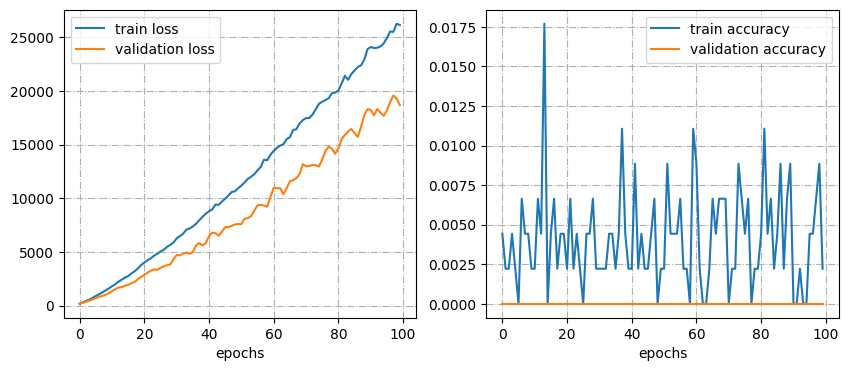

In [65]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(history_50.history['loss'])
axs[0].plot(history_50.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(history_50.history['accuracy'])
axs[1].plot(history_50.history['val_accuracy'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)